(sec_Notebooks_Grover)= 
# Algoritmo de Grover 

- **{ref}`sec_Notebooks_Grover_1`**
- **{ref}`sec_Notebooks_Grover_2`**
- **{ref}`sec_Notebooks_Grover_3`**
- **{ref}`sec_Notebooks_Grover_4`**
    - **{ref}`sec_Notebooks_Grover_4.1`**
    - **{ref}`sec_Notebooks_Grover_4.2`**
    - **{ref}`sec_Notebooks_Grover_4.3`**
    - **{ref}`sec_Notebooks_Grover_4.4`**

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator

In [2]:
# Importamos el simulador. Con "method" le especificamos el método de simulación
simulador = AerSimulator(method = 'statevector')

(sec_Notebooks_Grover_1)= 
## Puerta multicontrolada $Z$ (MCZ).   

Vamos a empezar viendo la implementación de la puerta multicontrolada $Z$ (MCZ) en qiskit, pues la usaremos bastante el las siguientes secciones. Esta puerta podemos construirla a partir de la puerta multicontrolada Toffoli (MCT) de forma muy sencilla. Para ello, recordemos que la MCT no es más que una CNOT (es decir, una puerta $X$) con varios controles y recordemos también la propiedad

```{math}
:label: Imple_HXH_Z 
\begin{equation} 
HXH = Z .
\end{equation} 
```

Podemos pues construir la MCZ aplicando puertas de Hadammard en el qúbit objetivo de la MCT antes y después de la misma. En código de qiskit esto nos queda 

In [3]:
def mcz(circuit, control_qubits, target_qubit):
    circuit.h(target_qubit)
    circuit.mct(control_qubits, target_qubit)  # multi-controlled-toffoli
    circuit.h(target_qubit)

/tmp/ipykernel_104226/1101216745.py:3: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circuit.mct(control_qubits, target_qubit)  # multi-controlled-toffoli
/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


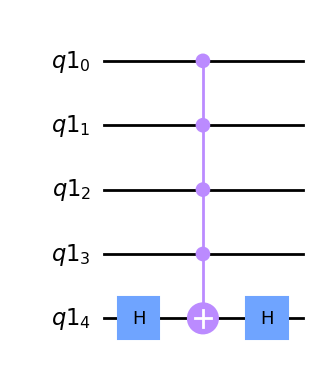

In [4]:
quamtum_reg_5 = QuantumRegister(5)
circuit_mcz = QuantumCircuit(quamtum_reg_5)
mcz(circuit_mcz, quamtum_reg_5[:4], quamtum_reg_5[4])
circuit_mcz.draw('mpl')

(sec_Notebooks_Grover_2)= 
##  Difusor genérico  

Como ya comentamos, habitualmente en vez de implementar $U_{\Psi_0}$ implementamos $-U_{\Psi_0}$. Vimos además que podemos hacer la implementación mediante transformadas de Walsh-Hadamard $H^{\otimes n}$, puertas $X^{\otimes n}$ y la puerta $MCZ$, es decir

```{math}
:label: ec_qiskit_diff-gen_U_Psi0 
\begin{equation} 
\boxed{-U_{\Psi_0}  = S_{\Psi_0}  = H^{\otimes n} S_0 H^{\otimes n} = H^{\otimes n} X^{\otimes n} (MCZ) X^{\otimes n} H^{\otimes n}} 
\end{equation} 
``` 

Veamos como traducir esta ecuación a código qiskit. 

In [5]:
def Grover_Diffuser(circuit, target_reg):
    
    n = target_reg.size

    # Apply transformation |s> -> |00..0> (H-gates)
    for i in range(n):
        circuit.h(target_reg[i])

    # Apply transformation |00..0> -> |11..1> (X-gates)
    for i in range(n):
        circuit.x(target_reg[i])

    # Do multi-controlled-Z gate
    mcz(circuit, target_reg[list(range(n-1))], target_reg[n-1])

    # Apply transformation |11..1> -> |00..0>
    for i in range(n):
        circuit.x(target_reg[i])

    # Apply transformation |00..0> -> |s>
    for i in range(n):
        circuit.h(target_reg[i])

La función anterior es genérica: dado un circuito y un registro cuántico, esta función aplica un difusor de Grover en el registro. Veamos un ejemplo

/tmp/ipykernel_104226/1101216745.py:3: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circuit.mct(control_qubits, target_qubit)  # multi-controlled-toffoli


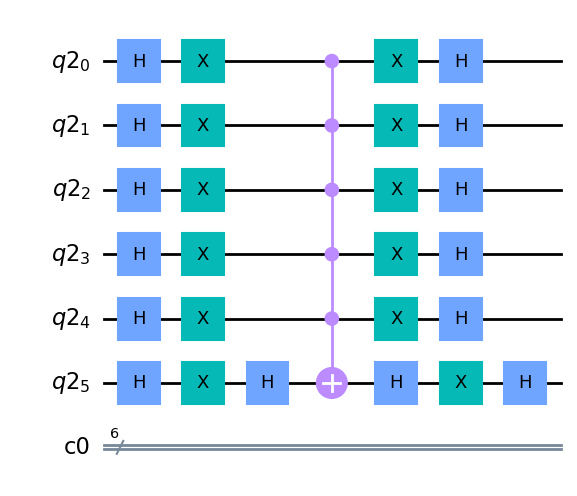

In [6]:
n = 6

quantum_reg = QuantumRegister(n)
classic_reg = ClassicalRegister(n)

circuit_difuser = QuantumCircuit(quantum_reg, classic_reg)

Grover_Diffuser(circuit_difuser, quantum_reg)

circuit_difuser.draw(output='mpl')

(sec_Notebooks_Grover_3)= 
## Oráculo Trivial   

Vamos a presentar en esta sección un código de qiskit para construir un oráculo que cambie el signo de los estados que nosotros le digamos. Este es uno de esos ejemplo típicos que se plantean cuando se habla de Grover, esos en los que sabemos con antelación los estados concretos que queremos buscar. De esta forma, el oráculo que construimos está hecho "ad hoc" para marcar ciertos estado. 

(Precisamente elegí llamarle a este caso "trivial" porque no entraña ningún misterio, sino que como comento es un caso académico.)

El código que se presenta a continuación es muy simple. Partimos de una lista de cadenas binarias de n bits que llamamos *M\_list\_bin\_qiskit*. Por ejemplo, para $n=5$

$$
M\_list\_bin\_qiskit = [\text{'} 01101 \text{'}, \text{'} 11000 \text{'}, ...]
$$

::::::{admonition} Nota
:class: note


     
Recordemos que en qiskit el bit menos significativo es que va arriaba en el circuito, así que en "qiskit" en el nombre de la lista <b>M\_list\_bin\_qiskit</b> hace referencia que estamos 
mandando las cadenas el revés. Es decir, para pasarlas a decimal las invertimos:


$$
01101 \quad \rightarrow \quad 10110 = 22, \qquad
11000 \quad \rightarrow \quad 00011 = 3
$$   
::::::
    

Para cambiar el signo de un estado lo que tenemos que hacer es aplicar una MCZ. Como esta solo aplica sobre el estado $|11\dots 1 \rangle$, lo que hay que hacer es aplicar puertas $X$ antes y después del la MCZ en los qúbit correspondientes a las posiciones donde tenemos un 0 en las cadenas bits.

In [7]:
def Grover_Oracle_trivial(circuit, target_reg, M_list_bin_qiskit): # n, M_list_bin):
	'''
	This function implements a Grover oracle. We call it "trivial" because this
	oracle change the sign of some given states. That is, we know the solution 
	in advance. (For example, we want to find the states |101> and |110> among 
	the 8 possible ones. We know from the begining the states we want to find.)

	We can use the multicontrolled Z gate (mcz) we defined earlier to change the
	sign of any M_list_bin[i] state. Simply apply X gates before and after the 
	mcz on the qubits that are worth zero in M_list_bin[i].

	IMPORTANT !!!: Remember that if we deal with qiskit, the binary strings have
	to 	come upside	down (with the LEASTE SIGNIFICANT BIT AT THE BEGINNING !!!).

	Inputs:
		- circuit: Quantum Circuit

		- target_reg: Quantum Register (with n qubits) in which we are going to 
			search and change the sign of some given states. It must be one 
			Quantum Register of the previus circuit.
		
		- M_list_bin: Python List with the states that we want to find. The 
			states must be in binary and must have length n.

	'''
	n = target_reg.size

	for m in M_list_bin_qiskit:
		for i in range(len(m)):
			if m[i] == '0':
				circuit.x(target_reg[i])

		mcz(circuit, target_reg[list(range(n-1))], target_reg[n-1])
	    
		for i in range(len(m)):
			if m[i] == '0':
				circuit.x(target_reg[i])

Veamos también una función que nos da el numero de iteraciones de Grover en función del número de soluciones $M$ y el número total de estados $N$:

In [8]:
def Iterations_T(N, M):
    
    return int(np.pi/4 * np.sqrt(N/M))

In [9]:
n = 4
N = 2**n # Total number of states
M_list_bin_qiskit = [ '0101', '1100']
M = len(M_list_bin_qiskit)

/tmp/ipykernel_104226/1101216745.py:3: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circuit.mct(control_qubits, target_qubit)  # multi-controlled-toffoli


The circuit has been built (4 qubits)

Number of Grover iteration: 2


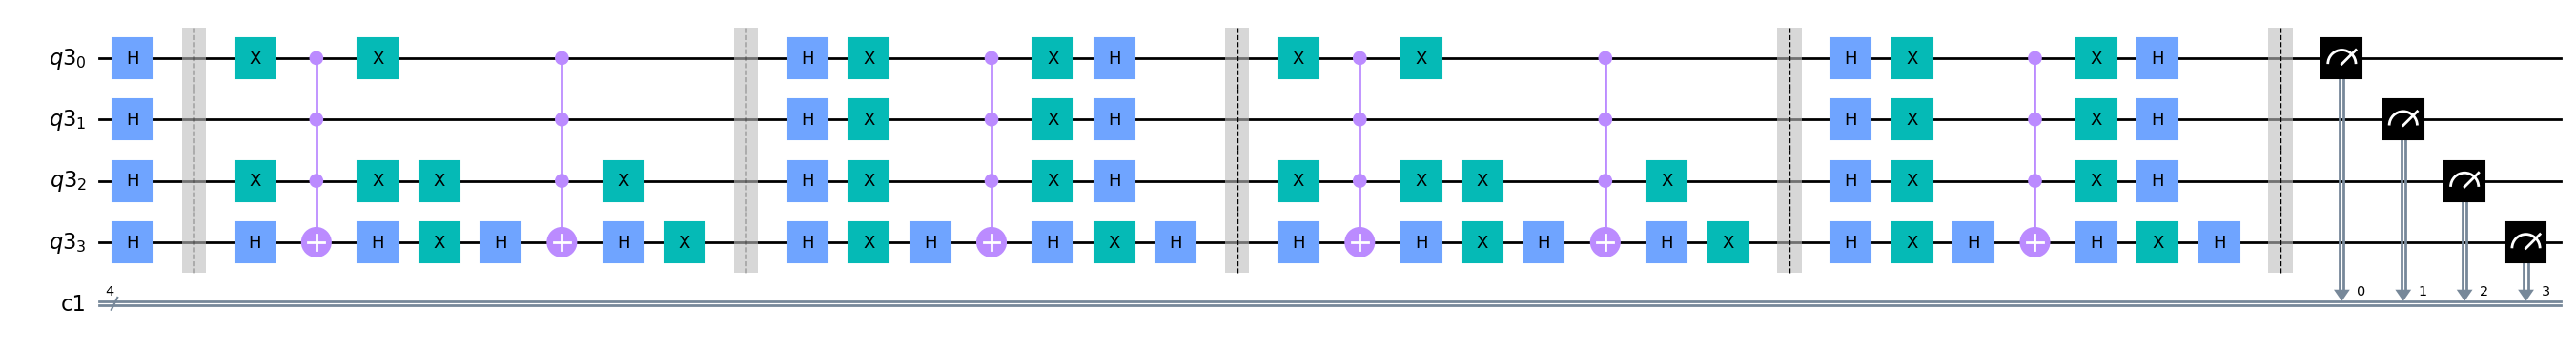

In [10]:
# We build the citcuit with the quantum registers
quantum_reg = QuantumRegister(n)
classic_reg = ClassicalRegister(n)
circuit_t = QuantumCircuit(quantum_reg, classic_reg)
    
# ======================================================
# We apply the initialization function. This time we use H^n
for qubit in quantum_reg:
    circuit_t.h(qubit)

circuit_t.barrier()
  
# ======================================================
# Number of iterations
T = Iterations_T(N, M)
       
# ======================================================
# We add the grover oracle and diffuser T times

for _ in range(T):
    Grover_Oracle_trivial(circuit_t, quantum_reg, M_list_bin_qiskit)
    circuit_t.barrier()
    Grover_Diffuser(circuit_t, quantum_reg)
    circuit_t.barrier()

# ======================================================
# Measure all qubits on the quantum_reg into the classic_reg

circuit_t.measure(quantum_reg, classic_reg)

# ======================================================
print(f'The circuit has been built ({n} qubits)')
print(f'\nNumber of Grover iteration: {T}')
print('====================================================')
circuit_t.draw('mpl', fold = -1)

In [11]:
sim = AerSimulator(method = 'statevector') 

t_circuit_t = transpile(circuit_t, backend = sim) #, optimization_level = 3)
result = sim.run(t_circuit_t, shots = 10000).result()

counts = result.get_counts()

# ======================================================
# We order the states from most counts to least

# keys = list(counts.keys())

keys_bin = list(counts.keys())
keys = keys_bin
#keys = [int(keys_bin[i],2) for i in range(len(keys_bin))] 

values = list(counts.values())
zip_list = zip(keys,values)
zip_sorted = list(sorted(zip_list, key = lambda x: -x[1]))
keys, values = zip(*list(zip_sorted))
        
num_sols = len(list(zip_sorted))
        
print_range = M + 2 
if num_sols < print_range:
    print_range = num_sols

print(f'\nThe algorithm found {num_sols} results.')
print(f'The {print_range} results with more counts are:')
print('\n   Result | Counts')
for i in range(print_range):
    print('   ',list(zip_sorted)[i])



The algorithm found 16 results.
The 4 results with more counts are:

   Result | Counts
    ('1010', 4802)
    ('0011', 4671)
    ('0100', 47)
    ('1011', 46)


::::::{admonition} Nota
:class: note


     
Si nos fijamos, vemos que nos devuelve las lista binarias el revés (1010 en vez de 0101) 
::::::


(sec_Notebooks_Grover_4)= 
##  Oráculos que verifican condiciones: Sudoku $2\times 2$ 

En esta sección vamos a ver como se puede usar el algoritmo de Grover para buscar cadenas de bits que satisfacen unas ciertas condiciones. En concreto vamos a ver dos caso: como solucionar un **sudoku** $2 \times 2$

(sec_Notebooks_Grover_4.1)= 
### El sudoku

Vamos a ver en esta sección como construir un oráculo que resuelva un sudoku 2x2 de la forma:
\begin{equation}
	\left(
	\begin{matrix}
	V_0 & V_1 \\
	V_2 & V_3
	\end{matrix}
	\right)
\end{equation}

(sec_Notebooks_Grover_4.2)= 
### Condiciones y puerta XOR

En un sudoku tiene que cumplirse que no se repitan números en las filas ni en las columnas, así que las condiciones que tienen que verificar las variables de sudoku 2x2 son:
\begin{equation}
V_0 \neq V_1, \qquad 
V_0 \neq V_2, \qquad
V_2 \neq V_3, \qquad
V_1 \neq V_3.
\end{equation}

Por comodidad, podemos compilar este conjunto de comparaciones en una lista de cláusulas:

In [12]:
conditions_list = [ [0,1],  [0,2],  [1,3],  [2,3] ]

Para verificar estas condiciones podemos usar un qúbit ancilla y usar la puerta XOR (se puede ver el código a continuación). Como el qúbit ancilla parte del estado $|0\rangle$, esta puerta lo que hace ponerlo a en el estado $|1\rangle$ si la condición se verifica.

In [13]:
def XOR_2qubits(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


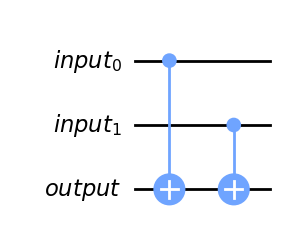

In [14]:
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR_2qubits(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw(output = 'mpl')

(sec_Notebooks_Grover_4.3)= 
### Oráculo

Para generar el oráculo del sudoku podemos usar 4 qúbits ancila (uno por condición a verificar) y usar la puerta XOR 4 veces. Pero con esto aún no tenemos el oráculo, pues nos falta verificar si todas las condiciones se cumplen y cambiar el signo del estado. 

Para ello, podemos usar una puerta MCT que tenga como controles los 4 qúbits ancilla y que se aplique sobre un quinto qúbit que esté en el estado $|-\rangle$. De esta forma, la puerta MCT solo se aplicará si se cumplen las 4 condiciones. 

Por último, solo nos faltaría volver a aplicar las puertas XOR para limpiar los qúbits ancilla. El resultado final sería el siguiente:

In [15]:
def Grover_Oracle_Sudoku_2x2(circuit, conditions_list, ancilla_reg, 
			                 output_qubit, print_oracle = 1):
	'''
	This oracle solves the problem of a Sudoku 2x2. 
	'''
	# Compute clauses
	i = 0
	for clause in conditions_list:
		XOR_2qubits(circuit, clause[0], clause[1], ancilla_reg[i])
		i += 1

	# Flip 'output' bit if all clauses are satisfied
	circuit.mct(ancilla_reg, output_qubit)

	# Uncompute clauses to reset clause-checking bits to 0
	i = 0
	for clause in conditions_list:
		XOR_2qubits(circuit, clause[0], clause[1], ancilla_reg[i])
		i += 1

	if print_oracle == 0:
		circuit.draw(output='mpl', fold = -1, filename = '3-Fig_Oracle_Sudoku_2x2')

(sec_Notebooks_Grover_4.4)= 
### Circuito final

Veamos también una función que nos da el numero de iteraciones de Grover en función del número de soluciones $M$ y el número total de estados $N$:

In [16]:
def Iterations_T(N, M):
    
    return int(np.pi/4 * np.sqrt(N/M))

/tmp/ipykernel_104226/4069349661.py:13: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circuit.mct(ancilla_reg, output_qubit)
/tmp/ipykernel_104226/1101216745.py:3: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circuit.mct(control_qubits, target_qubit)  # multi-controlled-toffoli


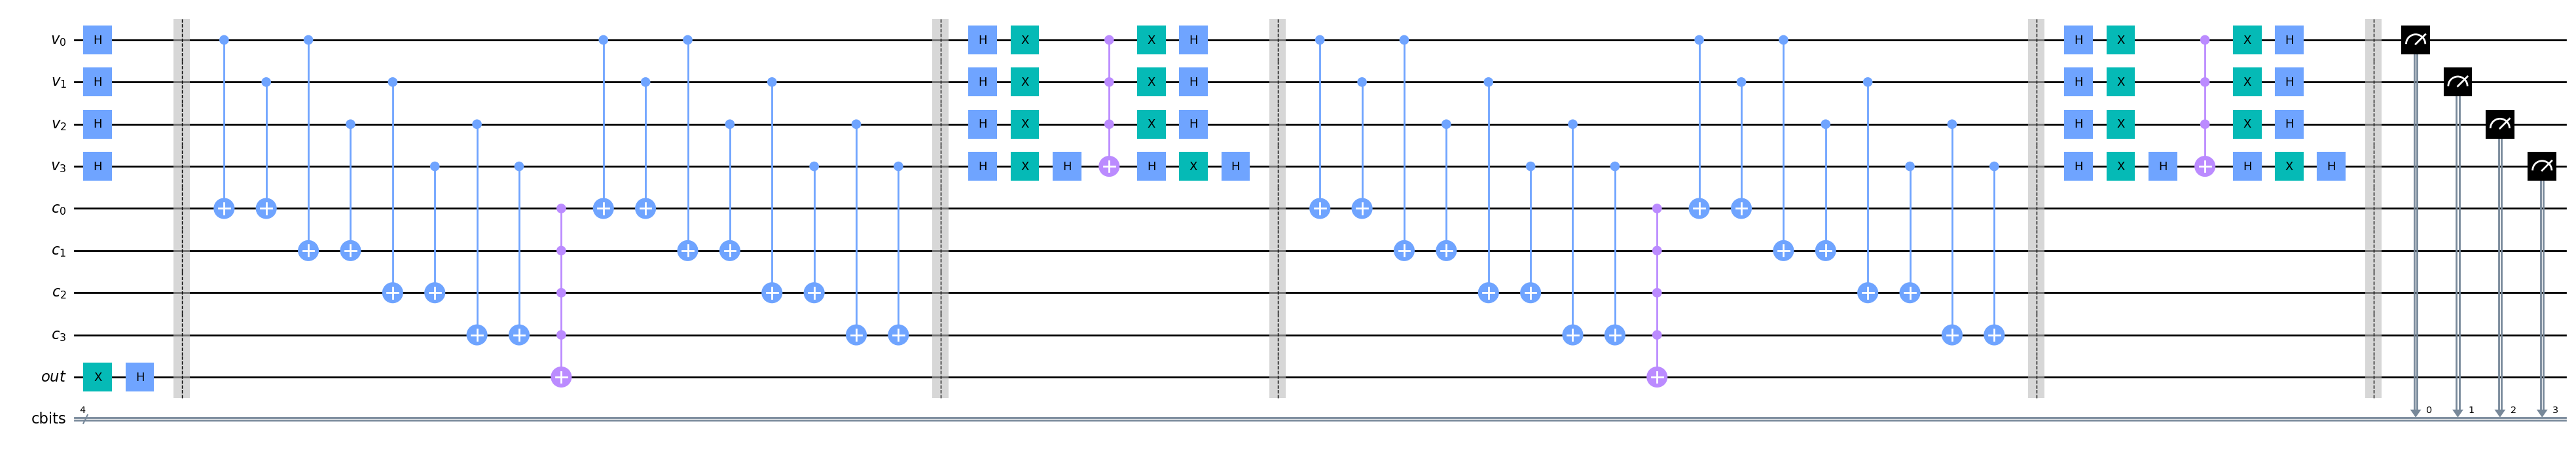

In [17]:
conditions_list = [ [0,1],  [0,2],  [1,3],  [2,3] ]

n = 4
N = 2**n # Total number of states
M = 2    # Number of solutions

# Registers
var_reg = QuantumRegister(n, name='v')
ancilla_reg = QuantumRegister(len(conditions_list), name='c')
output_qubit = QuantumRegister(1, name='out')
classic_reg = ClassicalRegister(n, name='cbits')

# Circuit
circuit_sudo = QuantumCircuit(var_reg, ancilla_reg, output_qubit, classic_reg)

# Initialize 'out0' in state |->
circuit_sudo.x(output_qubit)
circuit_sudo.h(output_qubit)

# Initialize qubits in state |s>
circuit_sudo.h(var_reg)
circuit_sudo.barrier()  # for visual separation

T = Iterations_T(N,M)

for i in range(T):
    Grover_Oracle_Sudoku_2x2(circuit_sudo, conditions_list, ancilla_reg, 
                  output_qubit, print_oracle = 1)
    circuit_sudo.barrier()  # for visual separation
    Grover_Diffuser(circuit_sudo, var_reg)
    circuit_sudo.barrier()  # for visual separation



# Measure the variable qubits
circuit_sudo.measure(var_reg, classic_reg)


circuit_sudo.draw(output='mpl', fold = -1)



Solving the sudoku 2x2:
    v0  v1
    v2  v3
The results takes the form: v0v1v2v3

The algorithm found 16 results.
The 4 results with more counts are:

   Result | Counts
   ('1001', 500)
   ('0110', 465)
   ('0001', 9)
   ('0101', 9)


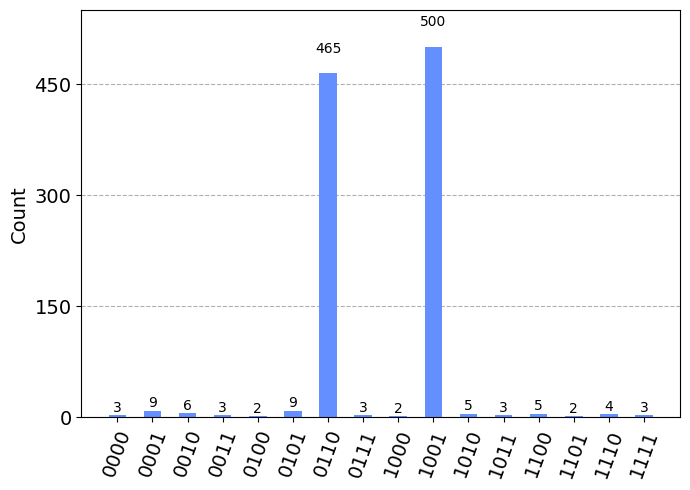

In [18]:
sim = AerSimulator(method = 'statevector')
t_circuit_sudo = transpile(circuit_sudo, sim)
result = sim.run(t_circuit_sudo).result()

counts = result.get_counts()

keys_bin = list(counts.keys())


values = list(counts.values())
zip_list = zip(keys_bin,values)
zip_sorted = list(sorted(zip_list, key = lambda x: -x[1]))
keys_bin, values = zip(*list(zip_sorted))

num_sols = len(list(zip_sorted))

print_range = 2 + 2 
if num_sols < print_range:
    print_range = num_sols

print('Solving the sudoku 2x2:')
print('    v0  v1')
print('    v2  v3')
print('The results takes the form: v0v1v2v3')
print(f'\nThe algorithm found {num_sols} results.')
print(f'The {print_range} results with more counts are:')
print('\n   Result | Counts')
for i in range(print_range):
    print('  ',list(zip_sorted)[i])

fig = plot_histogram(result.get_counts())

fig.tight_layout()

fig